<a href="https://colab.research.google.com/github/manualrg/dslab-nlp-dl/blob/master/03_intronlp_nbayes_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificacion Supervisada: NB

In [1]:
import typing

import numpy as np
import pandas as pd
import sklearn
import nltk

from sklearn.datasets import fetch_20newsgroups
from sklearn import preprocessing
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

In [2]:
print(f"{sklearn.__version__=}")
print(f"{nltk.__version__=}")
print(f"{pd.__version__=}")

sklearn.__version__='1.6.1'
nltk.__version__='3.9.1'
pd.__version__='2.2.2'


In [3]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
RND_SEED = 123
PCT_TEST = 0.2

# Dataset

In [5]:
df_data = pd.read_csv("hf://datasets/MariaIsabel/FR_NFR_Spanish_requirements_classification/New Spanish Academic Dataset.csv")
# para este dataset, no hace falta cuenta de HF
df_data.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,PROJECT,REQUIREMENT,FINAL_LABEL
0,16,Poder crear un usuario y acceder a través de é...,NF
1,16,Poder crear un perfil personal e individual a ...,F
2,16,Acceder a la aplicación y a sus funcionalidade...,NF
3,16,Todos los datos introducidos podrán ser leídos...,NF
4,16,"Poder leer, eliminar, editar o incluir cualqui...",F


In [6]:
df_data['FINAL_LABEL'].value_counts(normalize=True)

,proportion
FINAL_LABEL,
F,0.771208
NF,0.228792


In [7]:
df_data['y_is_nf'] =  df_data['FINAL_LABEL'].replace({"F": 0, "NF": 1})
df_data['y_is_nf'].value_counts(normalize=True)
df_data['x_text'] = df_data['REQUIREMENT']

<ipython-input-7-a0665addef4f>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['y_is_nf'] =  df_data['FINAL_LABEL'].replace({"F": 0, "NF": 1})


# Split

In [8]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    df_data["x_text"],
    df_data["y_is_nf"],
    test_size=PCT_TEST,
    random_state=RND_SEED,
    stratify=df_data["y_is_nf"]
)

# Tokenization

In [9]:
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

# Tokenization and stemming
class SpanishStemTokenizer:
    def __init__(self):
        self.stemmer = SnowballStemmer("spanish")

    def __call__(self, text) -> typing.List[str]:
        return [self.stemmer.stem(word) for word in word_tokenize(text) if word not in string.punctuation]

tokenizer_es = SpanishStemTokenizer()
stopwords_es = nltk.corpus.stopwords.words('spanish')

stopwords_es_tok = list(set([tokenizer_es(term.lower())[0] for term in stopwords_es]))


In [10]:
y_train.value_counts(normalize=True)

,proportion
y_is_nf,
0,0.771704
1,0.228296


In [11]:
from sklearn.metrics import f1_score

def compute_f1(X_test, y_test, skl_pl, positive_class = 1):
  y_pred = skl_pl.predict(X_test)

  return  f1_score(y_test, y_pred, pos_label=positive_class)

# NB: Binary TF

In [17]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

tfbin_unigrams = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    tokenizer=SpanishStemTokenizer(),
    stop_words=stopwords_es_tok,
    analyzer="word",
    ngram_range=(1, 1),
    binary=True
)

clf_nbber = BernoulliNB()

# Create the pipeline
skl_pl_exp1 = Pipeline([
    ('fte', tfbin_unigrams),
    ('clf', clf_nbber)
])

skl_pl_exp1.fit(X_train, y_train)

f1_score_train_exp1 = compute_f1(X_test, y_test, skl_pl_exp1)
f1_score_test_exp1 = compute_f1(X_test, y_test, skl_pl_exp1)


print(f"{f1_score_test_exp1=}")

f1_score_test_exp1=0.6428571428571429


In [ ]:
X_train_fte = tfbin_unigrams.transform(X_train)

X_train_fte.max(axis=0).todense().max() == 1  # todos los elementos de la DTM son 0 o 1

In [18]:
X_train_fte.shape

(311, 813)

# NB: TF

In [19]:
tf_unigrams = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    tokenizer=SpanishStemTokenizer(),
    stop_words=stopwords_es_tok,
    analyzer="word",
    ngram_range=(1, 1),
    binary=False
)

clf_nbmul = MultinomialNB()

# Create the pipeline
skl_pl_exp2 = Pipeline([
    ('fte', tf_unigrams),
    ('clf', clf_nbmul)
])

skl_pl_exp2.fit(X_train, y_train)

f1_score_train_exp2 = compute_f1(X_test, y_test, skl_pl_exp2, )
f1_score_test_exp2 = compute_f1(X_test, y_test, skl_pl_exp2)


print(f"{f1_score_test_exp2=}")

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tambi'] not in stop_words.
  warnings.warn(


f1_score_test_exp2=0.7878787878787878


In [21]:
X_train_fte_exp2 = tf_unigrams.transform(X_train)

X_train_fte_exp2.max(axis=0).todense()

matrix([[ 1,  1,  1,  1,  1,  1,  5,  2,  1,  1,  1,  1,  1,  2,  1,  1,
          3,  1,  1,  1,  2,  2,  1,  1,  2,  1,  1,  1,  2,  1,  1,  1,
          1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,
          2,  3,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  3,  1,  2,  1,
          1,  1,  2,  1,  1,  2,  1,  1,  1,  1,  2,  1,  2,  3,  1,  1,
          1,  1,  2,  1,  3,  1, 11,  1,  2,  1,  1,  1,  2,  1,  2,  1,
          1,  2,  1,  1,  1,  2,  1,  2,  2,  3,  4,  1,  3,  2,  1,  1,
          1,  1,  1,  1,  1,  2,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  2,  1,  1,  1,  2,  1,  1,  1,  2,  1,  5,  1,  2,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,
          1,  2,  2,  1,  1,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  2,  1,  1,  2,  1,  2,  1,  2,  2,  1,  3,  1,
          3,  1,  1,  1,  1,  2,  2,  1,  2,  1,  1,  1,  2,  2,  1,  1,
          1,  3,  2,  1,  3,  1,  1,  1,  2,  2,  3

# NB: TF + bigrams

In [22]:
tf_unigrams = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    tokenizer=SpanishStemTokenizer(),
    stop_words=stopwords_es_tok,
    analyzer="word",
    ngram_range=(1, 2),
    max_features=16,
    binary=False
)


tf_bigrams = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    tokenizer=SpanishStemTokenizer(),
    stop_words=stopwords_es_tok,
    analyzer="word",
    ngram_range=(2, 2),
    max_features=16,
    binary=False
)


# Create a FeatureUnion to combine the outputs of the transformers
feature_union = FeatureUnion([
    ('unigrams', tf_unigrams),
    ('bigrams', tf_bigrams)
])

clf_nbmul = MultinomialNB()

# Create the pipeline
skl_pl_exp3 = Pipeline([
    ('fte', feature_union),
    ('clf', clf_nbmul)
])

skl_pl_exp3.fit(X_train, y_train)

f1_score_train_exp3 = compute_f1(X_test, y_test, skl_pl_exp3, )
f1_score_test_exp3 = compute_f1(X_test, y_test, skl_pl_exp3)


print(f"{f1_score_test_exp3=}")

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['tambi'] not in stop_words.
  warnings.warn(


f1_score_test_exp3=0.6666666666666666


# Benchmark

In [23]:
pd.Series(
    index=["nb-ber", "nb-multi", "nb-multi-bigrams"],
    data=[f1_score_test_exp1, f1_score_test_exp2, f1_score_test_exp3],
    name='f1_score'
)

,f1_score
nb-ber,0.642857
nb-multi,0.787879
nb-multi-bigrams,0.666667


# Champion

In [24]:
skl_pl_champ = skl_pl_exp2

nb_champ = skl_pl_champ.named_steps['clf']

# Debug

In [25]:
X_train.head()

,x_text
385,Respuestas coherentes e idénticas ante entrada...
299,Gestión de usuarios: Todos los administradores...
224,Añadir numero de una revista. Para ello debemo...
103,Un usuario registrado visualiza la tabla de en...
198,Como usuario quiero poder ordenar las listas d...


In [26]:
X_train.shape

(311,)

In [27]:
df_data['y_is_nf'].value_counts()

,count
y_is_nf,
0,300
1,89


In [28]:
X_debug = pd.Series([
    "El boton de cálculo devuelve datos erróneos",
    "El grafico no muestra las unidades en losejes",
    "La latencia de la aplicación es muy alta, debe ejecutarse en tiempo lineal",
    "The authentification page does not let you see the password to verify",
    "Aplikazioaren latentzia oso handia da, denbora linealean exekutatu beharko litzateke.",
    "La latència de l'aplicació és molt alta, s'hauria d'executar en temps lineal."

], name='x_text')


skl_pl_champ.predict(X_debug)

array([0, 0, 1, 0, 0, 0])

In [29]:
X_debug_fte = skl_pl_champ.named_steps['fte'].transform(X_debug)

In [30]:
X_debug_fte.sum(axis=1)

matrix([[3],
        [2],
        [6],
        [1],
        [2],
        [2]])

In [31]:
# ¿Qué está haciendo el modelo?

X_train_fte = skl_pl_champ.named_steps['fte'].transform(X_train)
X_test_fte = skl_pl_champ.named_steps['fte'].transform(X_test)

df_tf_by_doc =  pd.DataFrame(
    index=X_test.index,
    data=X_test_fte.sum(axis=1),
    columns=["sum_tf_by_doc"])
df_tf_by_doc['y_is_nf'] = y_test

df_tf_by_doc.groupby("y_is_nf")['sum_tf_by_doc'].describe()

,count,mean,std,min,25%,50%,75%,max
y_is_nf,,,,,,,,
0,60.0,14.250000,10.932187,3.0,6.0,10.5,19.5,42.0
1,18.0,8.111111,3.512815,3.0,6.0,7.5,10.0,18.0


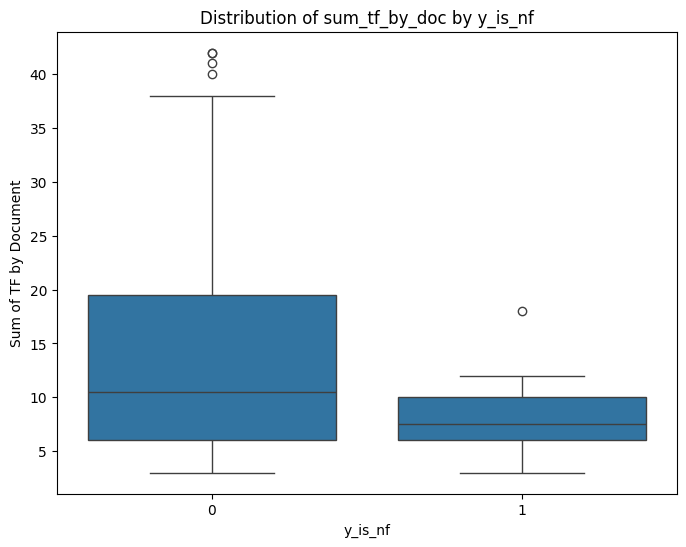

In [32]:
# prompt: plot the distribuitions over 'FINAL_LABEL' of column `sum_tf_by_doc` in `df_tf_by_doc`

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.boxplot(x='y_is_nf', y='sum_tf_by_doc', data=df_tf_by_doc)
plt.title('Distribution of sum_tf_by_doc by y_is_nf')
plt.xlabel('y_is_nf')
plt.ylabel('Sum of TF by Document')
plt.show()

¿Qué hace el modelo?
* Los textos de la clase mayoritaria (en este caso 'F') hacen más matches a lo largo de su fila de la DTM
* Por otro lado, los de la clase minoritaria exhiben el comportamiento contrario
* Sin embargo, si hubiera textos en otros idiomas (porque en producción entrasen sin ser detectados), harían pocos matches en la DTM e irían a la clase 'F', que es la mayoritaria y captura el 'ruido' , observándose un `sesgo de predicción` en dicha clase en producción

# Importancia de variables

In [33]:
P_xi_y = nb_champ.feature_log_prob_ # Empirical log probability of features given a class, P(x_i|y).
P_xi_y.shape  # [classes, n_features]

(2, 813)

In [34]:
feat_imp = P_xi_y[1] - P_xi_y[0]  # clase 1 vs clase 0
top_features = pd.DataFrame({
    'feature':  skl_pl_champ.named_steps['fte'].get_feature_names_out(),
    'feature_importance': feat_imp
}).sort_values(by='feature_importance', ascending=False)

print(top_features.head())

      feature  feature_importance
445    intuit            3.286657
438  interfaz            3.035342
338     facil            2.881192
159  conexion            2.881192
124      cerr            2.698870


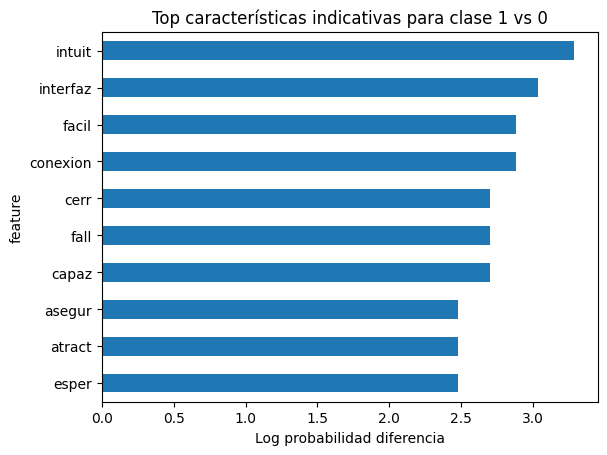

In [35]:
top_n = 10
top_features[:top_n].plot(kind='barh', x='feature', y='feature_importance', legend=False)
plt.title("Top características indicativas para clase 1 vs 0")
plt.xlabel("Log probabilidad diferencia")
plt.gca().invert_yaxis()
plt.show()

<Figure size 1000x600 with 0 Axes>

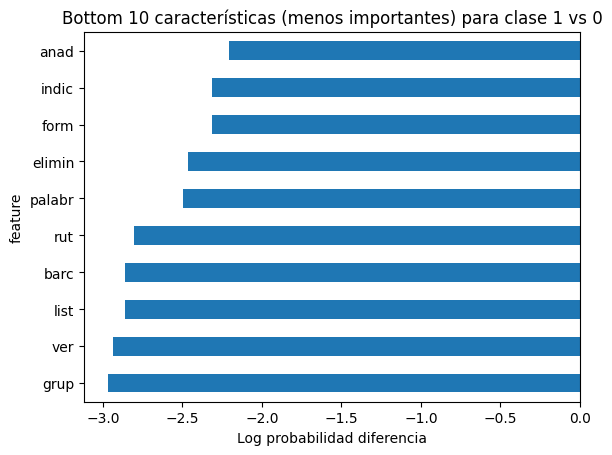

In [36]:
bottom_n = 10

plt.figure(figsize=(10, 6))

top_features[-bottom_n:].sort_values(by='feature_importance', ascending=True).plot(kind='barh', x='feature', y='feature_importance', legend=False)
plt.title(f"Bottom {bottom_n} características (menos importantes) para clase 1 vs 0")
plt.xlabel("Log probabilidad diferencia")
plt.show()

# Ejercicio
1. Implementar una pipeline de clasificación basada en [Regresion Logistica](LogisticRegression), ensayando los tipos de vectorización que sean mas convenientes
2. Obtener el f1-score de test
3. Obtener los 5 términos más importantes para el modelo
